In [9]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt
import time 
import torch.nn.utils.spectral_norm as spectral_norm

In [7]:
train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = False,
    transform = ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = False,
    transform = ToTensor()
)

train_dataloader = DataLoader(train_dataset, batch_size = 64)
test_dataloader = DataLoader(test_dataset, batch_size = 64)

device = 'cuda'

In [72]:
BATCH_SIZE = 64 
LEARNING_RATE = 2e-4
N_EPOCHS = 10
LEAKY_SLOPE = 0.2
B1_MOMENTUM = 0.5
Z_DIM = 100 
IMAGE_DIM = 28 * 28
HIDDEN_DIM = 128
N_CHANNELS = 1
D_ITER = 5


In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim = Z_DIM, h_dim = HIDDEN_DIM, x_dim = IMAGE_DIM):
        super().__init__()
        self.fc = nn.Linear(z_dim, h_dim * 7 * 7)
        self.gen_stack = nn.Sequential(
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size =4, stride = 2, padding = 1),
            nn.BatchNorm2d(h_dim // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim // 2, N_CHANNELS, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), HIDDEN_DIM, 7, 7)
        x = self.gen_stack(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            

torch.Size([64, 1, 28, 28])


In [34]:
def gradient_penalty(discriminator, generator, real_data, fake_data):
    batch_size, c, h, w = real_data.shape
    eps = torch.randn((batch_size, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_image = eps*real_data + (1 - eps)*fake_data

    interpolated_score = discriminator(interpolated_image)
    interpolated_gradients = torch.autograd.grad(
        inputs = interpolated_image,
        outputs = interpolated_score,
        grad_outputs = torch.ones_like(interpolated_score),
        create_graph = True,
        retain_graph = True
    )[0]

    interpolated_gradients = interpolated_gradients.view(interpolated_gradients.shape[0], -1)
    gradients_norm = interpolated_gradients.norm(2, dim = 1)
    penalty_term = torch.mean((gradients_norm - 1)**2)
    return penalty_term 

In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc_stack = nn.Sequential(
            # nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1),
            # nn.InstanceNorm2d(HIDDEN_DIM // 2),
            # nn.LeakyReLU(LEAKY_SLOPE),
            # nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1),
            # nn.InstanceNorm2d(HIDDEN_DIM),
            # nn.LeakyReLU(LEAKY_SLOPE)
            spectral_norm(nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1)),
            nn.InstanceNorm2d(HIDDEN_DIM // 2),
            nn.LeakyReLU(LEAKY_SLOPE),
            spectral_norm(nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1)),
            nn.InstanceNorm2d(HIDDEN_DIM),
            nn.LeakyReLU(LEAKY_SLOPE)
        )
        self.fc = nn.Linear(HIDDEN_DIM * 7 * 7, 1)

    def forward(self, x):
        self._initialize_weights()
        x = self.disc_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)


In [87]:
gen_losses_avg = []
disc_losses_avg = []

def plot_images(generator, epoch, fixed_noise):
    generator.eval()
    fake_images = generator(fixed_noise).detach().cpu()
    fig = plt.figure(figsize = (8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i][0], cmap = 'gray')
        plt.axis('off')
    
    plt.show()
    generator.train()

def plot_losses(gen_losses, disc_losses):
    plt.plot(gen_losses, label = 'D(G(z))')
    plt.plot(disc_losses, label = 'D(x)')
    plt.ylim(-5, 9)
    plt.legend()
    plt.show()


In [88]:
g_losses = []
d_losses = []
gen_losses_avg = []
disc_losses_avg = []
epoch = 0
def train_loop(dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn):
    
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        batch_size = X.size(0)
        z = torch.randn(batch_size, Z_DIM).to(device)
        for _ in range(D_ITER):
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            fake_images = generator(z)
            fake_preds = discriminator(fake_images)

            gp = gradient_penalty(discriminator, generator, X, fake_images)

            real_preds = discriminator(X)

            d_loss = (
                -(torch.mean(real_preds) - torch.mean(fake_preds)) + 10*gp
            )

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            d_losses.append(d_loss.item())
        

        #train generator 
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, Z_DIM).to(device)
        fake_images = generator(z)
        fake_preds = discriminator(fake_images).reshape(-1)
        g_loss = -torch.mean(fake_preds)

        g_losses.append(g_loss.item())
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if batch % 100 == 0:
            print(f'Generator Loss: {g_loss.item()} Discriminator Loss: {d_loss.item()}')

    
    

Generator Loss: -1.1461849212646484 Discriminator Loss: 3858.661376953125
Generator Loss: 0.5546489953994751 Discriminator Loss: 2.899745225906372
Generator Loss: -0.8317607641220093 Discriminator Loss: -8.118752479553223
Generator Loss: 2.8371944427490234 Discriminator Loss: -3.842698097229004
Generator Loss: 4.527470588684082 Discriminator Loss: -4.153304100036621
Generator Loss: 2.0598971843719482 Discriminator Loss: -3.750619888305664
Generator Loss: 2.917177677154541 Discriminator Loss: -3.69465970993042
Generator Loss: 2.8158535957336426 Discriminator Loss: -3.804152727127075
Generator Loss: 0.2987042963504791 Discriminator Loss: -3.0734498500823975
Generator Loss: 1.1723885536193848 Discriminator Loss: -3.9126152992248535
Epoch 1/10 took 118.37s


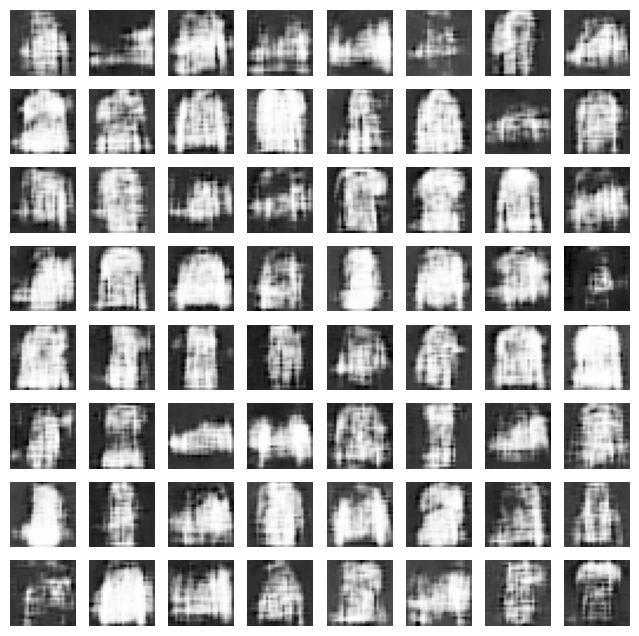

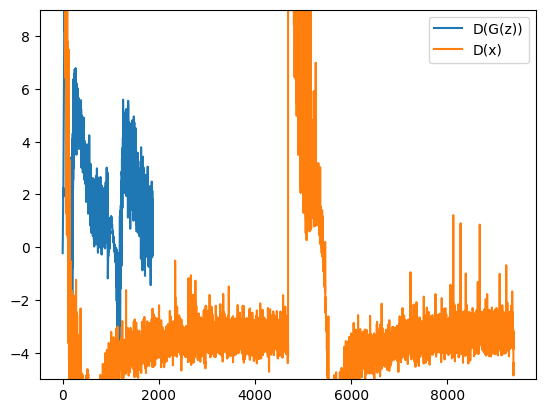

Generator Loss: 0.836647629737854 Discriminator Loss: -3.7672617435455322
Generator Loss: 1.7442528009414673 Discriminator Loss: -3.636976480484009
Generator Loss: 0.03173288702964783 Discriminator Loss: -3.3471198081970215
Generator Loss: 1.0264689922332764 Discriminator Loss: -2.7919507026672363
Generator Loss: 1.3210744857788086 Discriminator Loss: -3.534532070159912
Generator Loss: 0.7669960260391235 Discriminator Loss: -2.8009634017944336
Generator Loss: 2.4917571544647217 Discriminator Loss: -3.112344980239868
Generator Loss: 1.7553074359893799 Discriminator Loss: -2.9555280208587646
Generator Loss: 0.3286897540092468 Discriminator Loss: -2.998612403869629
Generator Loss: -0.1384640485048294 Discriminator Loss: -2.8879384994506836
Epoch 2/10 took 116.23s


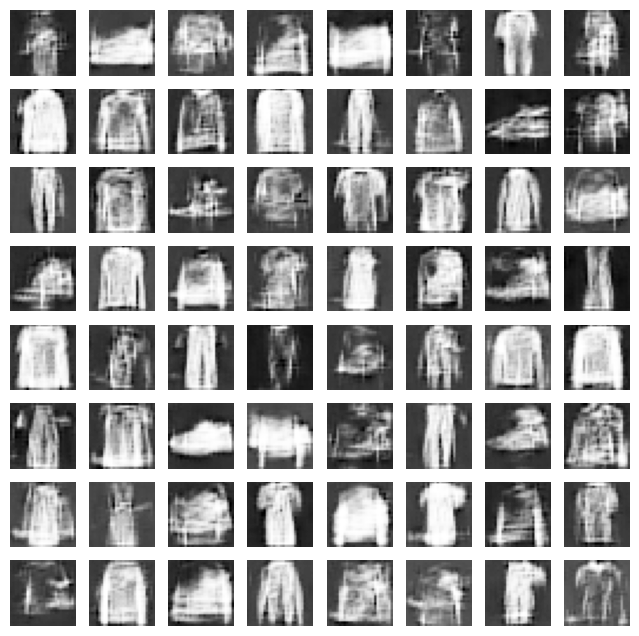

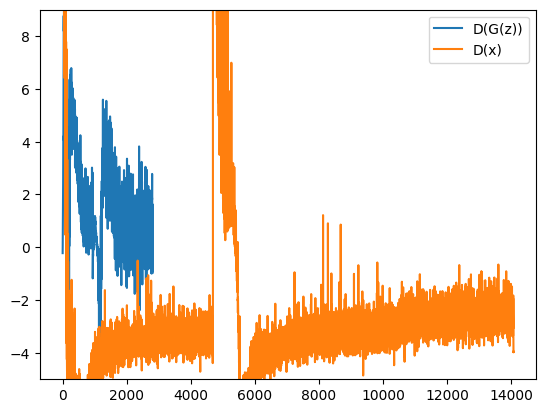

Generator Loss: 0.8227776885032654 Discriminator Loss: -3.011659860610962
Generator Loss: 2.0951738357543945 Discriminator Loss: -3.1668877601623535
Generator Loss: -0.5415217876434326 Discriminator Loss: -2.9627842903137207
Generator Loss: 1.699802041053772 Discriminator Loss: -2.449475049972534
Generator Loss: 0.35016030073165894 Discriminator Loss: -2.8757567405700684
Generator Loss: 0.20890136063098907 Discriminator Loss: -2.6462554931640625
Generator Loss: 1.3979244232177734 Discriminator Loss: -2.501481056213379
Generator Loss: 0.9483431577682495 Discriminator Loss: -2.8259904384613037
Generator Loss: -0.7663983106613159 Discriminator Loss: -2.7153337001800537
Generator Loss: 0.4943814277648926 Discriminator Loss: -2.539177656173706
Epoch 3/10 took 123.35s


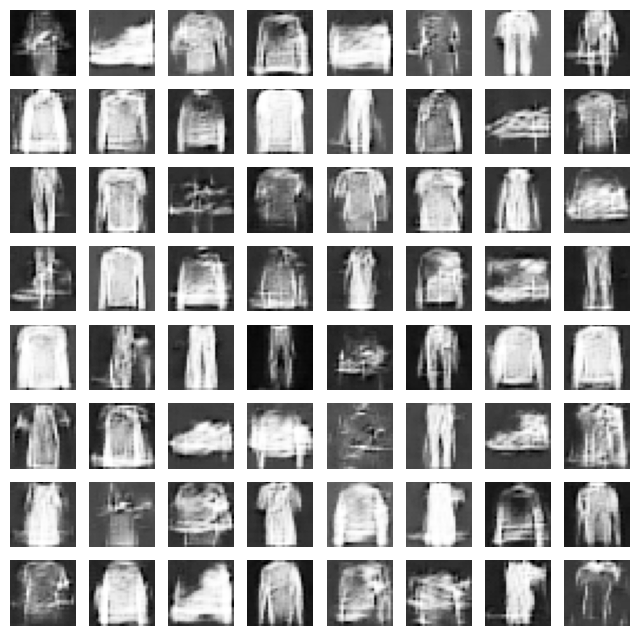

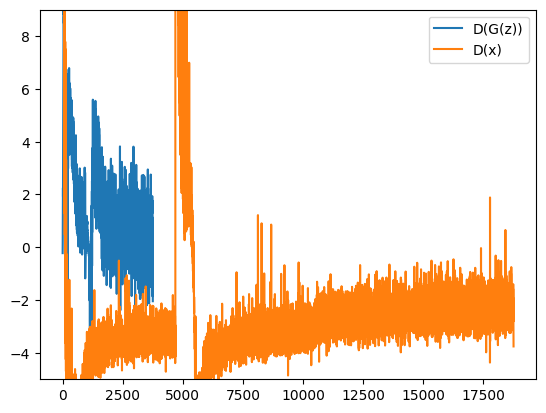

Generator Loss: 0.16543276607990265 Discriminator Loss: -2.887814521789551
Generator Loss: 2.1036882400512695 Discriminator Loss: -2.3129899501800537
Generator Loss: 0.9682241678237915 Discriminator Loss: -2.8250341415405273
Generator Loss: 0.8629187345504761 Discriminator Loss: -2.7058939933776855
Generator Loss: 0.7590200304985046 Discriminator Loss: -3.0419998168945312
Generator Loss: -0.5306921005249023 Discriminator Loss: -2.973998785018921
Generator Loss: 0.6906106472015381 Discriminator Loss: -2.356328010559082
Generator Loss: 0.6001734733581543 Discriminator Loss: -2.9138665199279785
Generator Loss: -1.189109444618225 Discriminator Loss: -2.528010845184326
Generator Loss: -0.2669593095779419 Discriminator Loss: -2.681565761566162
Epoch 4/10 took 118.77s


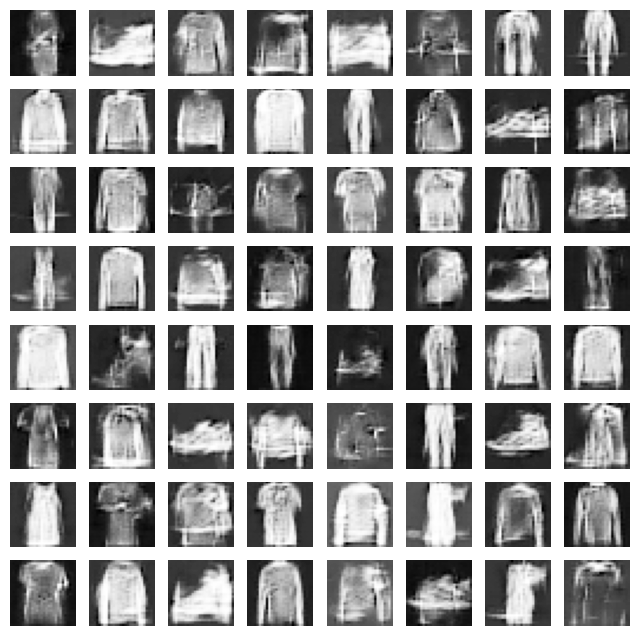

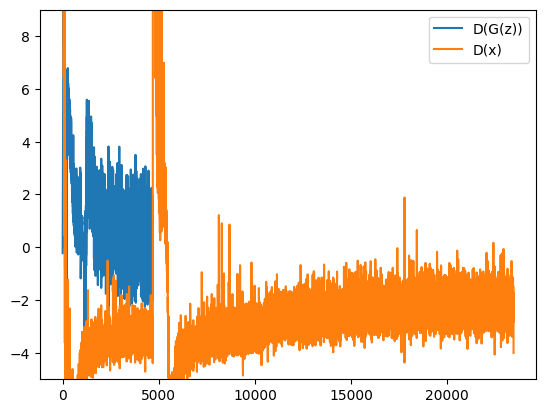

Generator Loss: -0.8210018873214722 Discriminator Loss: -2.703139066696167
Generator Loss: 1.6102643013000488 Discriminator Loss: -2.535464286804199
Generator Loss: 0.9194733500480652 Discriminator Loss: -2.8499481678009033
Generator Loss: 0.8184812664985657 Discriminator Loss: -2.330597162246704
Generator Loss: 0.22634518146514893 Discriminator Loss: -2.582515239715576
Generator Loss: 0.6862035989761353 Discriminator Loss: -2.713350296020508
Generator Loss: 1.1982061862945557 Discriminator Loss: -2.8235630989074707
Generator Loss: -0.45378053188323975 Discriminator Loss: -2.517141580581665
Generator Loss: -1.6436328887939453 Discriminator Loss: -3.2137951850891113
Generator Loss: 0.5652357339859009 Discriminator Loss: -2.647698402404785
Epoch 5/10 took 118.17s


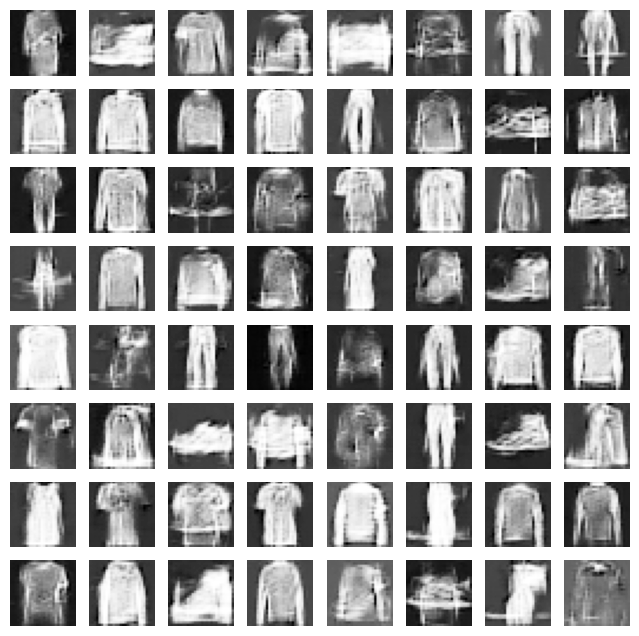

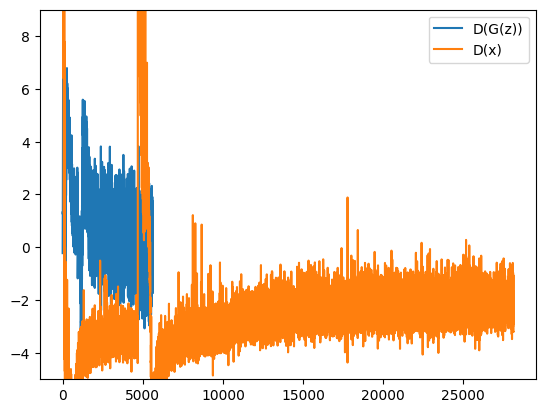

Generator Loss: -0.04814094305038452 Discriminator Loss: -2.6669726371765137
Generator Loss: 1.4704629182815552 Discriminator Loss: -2.6180286407470703
Generator Loss: -0.5805380940437317 Discriminator Loss: -2.725248336791992
Generator Loss: -0.8237931728363037 Discriminator Loss: -2.323448657989502
Generator Loss: -0.9227917790412903 Discriminator Loss: -2.8992347717285156
Generator Loss: -0.9162852764129639 Discriminator Loss: -2.4680614471435547
Generator Loss: 0.6019763350486755 Discriminator Loss: -2.291140079498291
Generator Loss: -0.6963760852813721 Discriminator Loss: -2.639871120452881
Generator Loss: -0.051768891513347626 Discriminator Loss: -2.859905958175659
Generator Loss: -0.02873273193836212 Discriminator Loss: -2.715527296066284
Epoch 6/10 took 124.34s


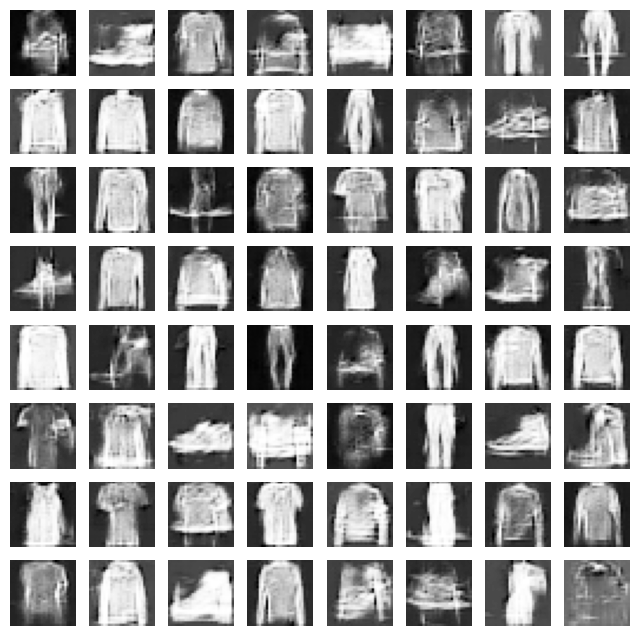

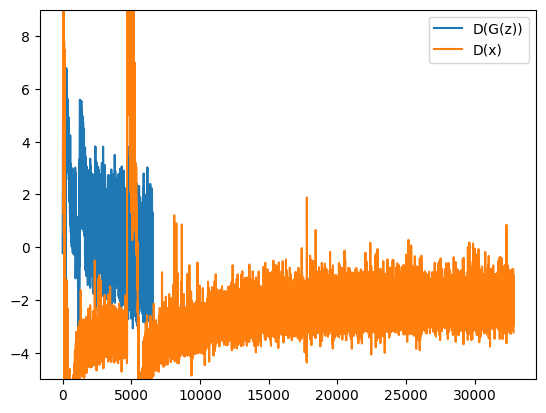

Generator Loss: -0.2914557456970215 Discriminator Loss: -2.5661630630493164
Generator Loss: 1.2434629201889038 Discriminator Loss: -2.5288243293762207
Generator Loss: -1.7523350715637207 Discriminator Loss: -2.518580675125122
Generator Loss: 0.7804912328720093 Discriminator Loss: -2.5006744861602783
Generator Loss: -0.41175103187561035 Discriminator Loss: -2.983574390411377
Generator Loss: -1.1763055324554443 Discriminator Loss: -2.6327736377716064
Generator Loss: 1.9169000387191772 Discriminator Loss: -2.8507442474365234
Generator Loss: 0.021145664155483246 Discriminator Loss: -2.501267433166504
Generator Loss: -1.2027896642684937 Discriminator Loss: -2.5401344299316406
Generator Loss: -1.299628734588623 Discriminator Loss: -2.5241494178771973
Epoch 7/10 took 120.50s


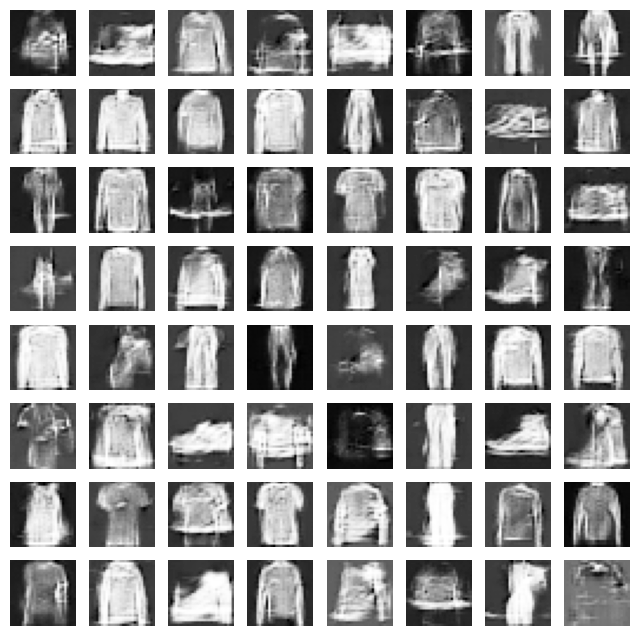

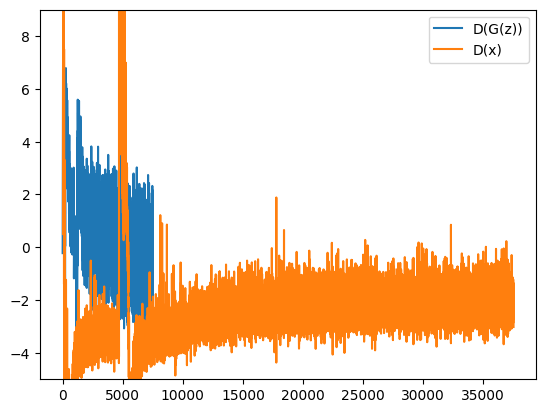

Generator Loss: -1.9988369941711426 Discriminator Loss: -2.110959768295288
Generator Loss: 1.045830488204956 Discriminator Loss: -2.4424679279327393
Generator Loss: -1.2267706394195557 Discriminator Loss: -2.5295467376708984
Generator Loss: 1.1903654336929321 Discriminator Loss: -2.478769063949585
Generator Loss: 0.19883118569850922 Discriminator Loss: -2.761310577392578
Generator Loss: -1.2329553365707397 Discriminator Loss: -2.541410207748413
Generator Loss: 1.2410259246826172 Discriminator Loss: -2.5816783905029297
Generator Loss: -0.018609996885061264 Discriminator Loss: -2.46347713470459
Generator Loss: -1.2926054000854492 Discriminator Loss: -2.5620124340057373
Generator Loss: -2.962536334991455 Discriminator Loss: -2.3221285343170166
Epoch 8/10 took 127.37s


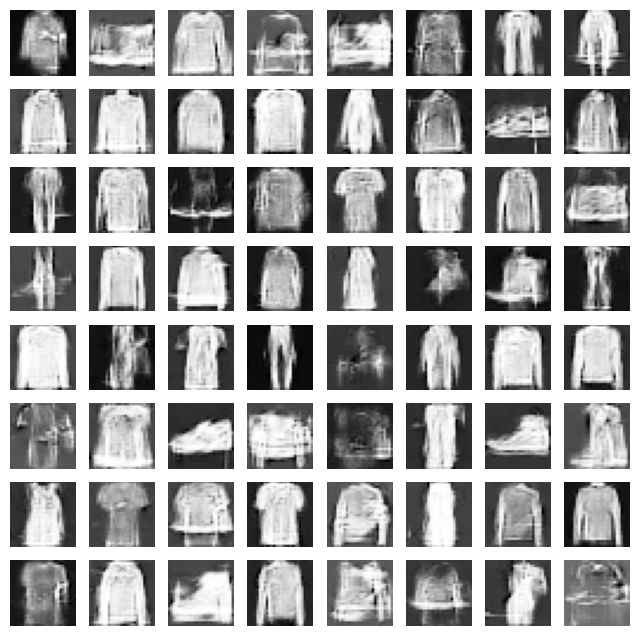

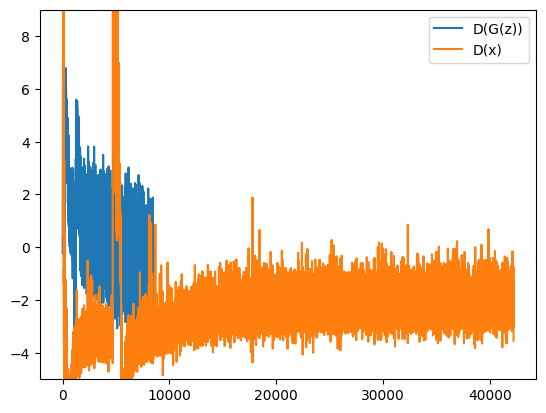

Generator Loss: -1.3487004041671753 Discriminator Loss: -2.41597843170166
Generator Loss: -1.1112391948699951 Discriminator Loss: -2.425360918045044
Generator Loss: 0.8307681083679199 Discriminator Loss: -2.4252994060516357
Generator Loss: 0.7019350528717041 Discriminator Loss: -2.130389928817749
Generator Loss: -0.17738434672355652 Discriminator Loss: -2.400851249694824
Generator Loss: -0.7464557886123657 Discriminator Loss: -2.6836624145507812
Generator Loss: 0.5069588422775269 Discriminator Loss: -2.416757583618164
Generator Loss: 0.11402682960033417 Discriminator Loss: -2.1717309951782227
Generator Loss: -1.1437275409698486 Discriminator Loss: -2.319593667984009
Generator Loss: -1.3372318744659424 Discriminator Loss: -2.5695900917053223
Epoch 9/10 took 117.79s


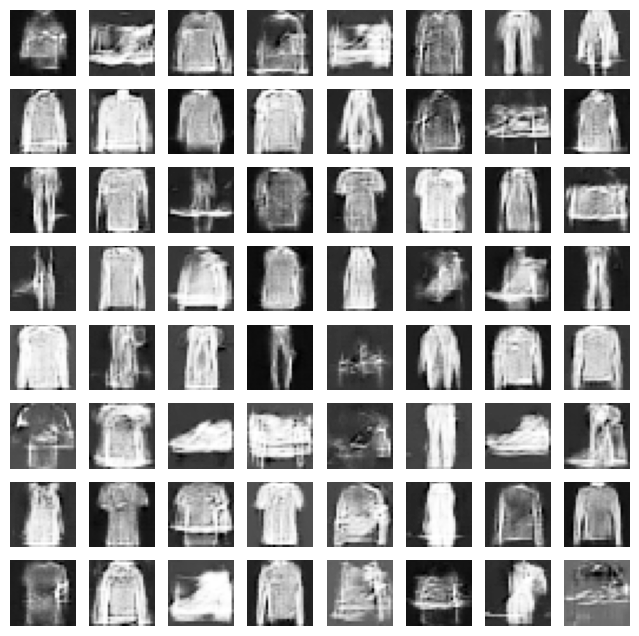

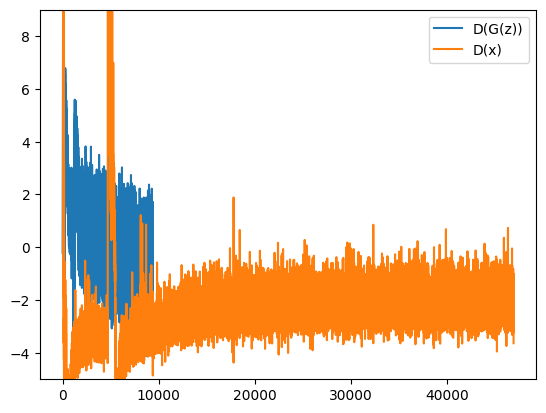

Generator Loss: -1.6223106384277344 Discriminator Loss: -2.2162861824035645
Generator Loss: -0.27543962001800537 Discriminator Loss: -2.264230966567993
Generator Loss: -0.7497058510780334 Discriminator Loss: -2.6630373001098633
Generator Loss: -1.1867589950561523 Discriminator Loss: -2.2671563625335693
Generator Loss: -1.0084419250488281 Discriminator Loss: -2.082332134246826
Generator Loss: -1.4505209922790527 Discriminator Loss: -2.660008192062378
Generator Loss: 0.444006085395813 Discriminator Loss: -2.5644068717956543
Generator Loss: -0.7772676944732666 Discriminator Loss: -2.1803479194641113
Generator Loss: -1.2223799228668213 Discriminator Loss: -2.056419610977173
Generator Loss: -0.2910163402557373 Discriminator Loss: -2.392657518386841
Epoch 10/10 took 128.15s


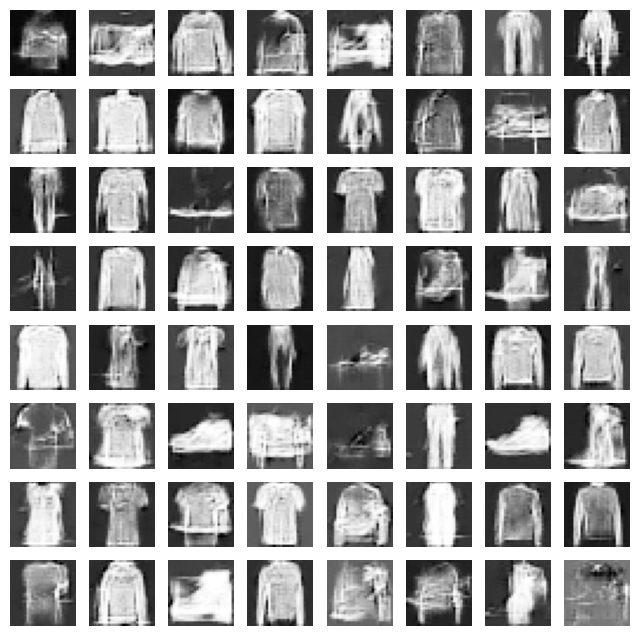

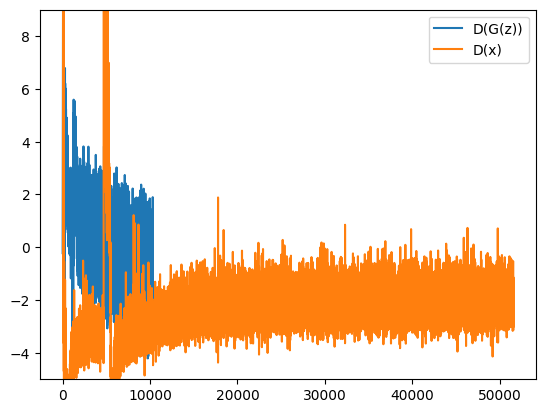

Training took 1221.57s


In [90]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr = LEARNING_RATE, betas=(0., 0.9))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = LEARNING_RATE, betas = (0., 0.9))

loss_fn = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(64, Z_DIM).to(device)

totaltime = time.time()
for epoch in range(N_EPOCHS):
    start = time.time()
    train_loop(train_dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn)
    print(f'Epoch {epoch + 1}/{N_EPOCHS} took {time.time() - start:.2f}s')
    plot_images(generator, epoch, fixed_noise)
    plot_losses(g_losses, d_losses)
    

print(f'Training took {time.time() - totaltime:.2f}s')
    